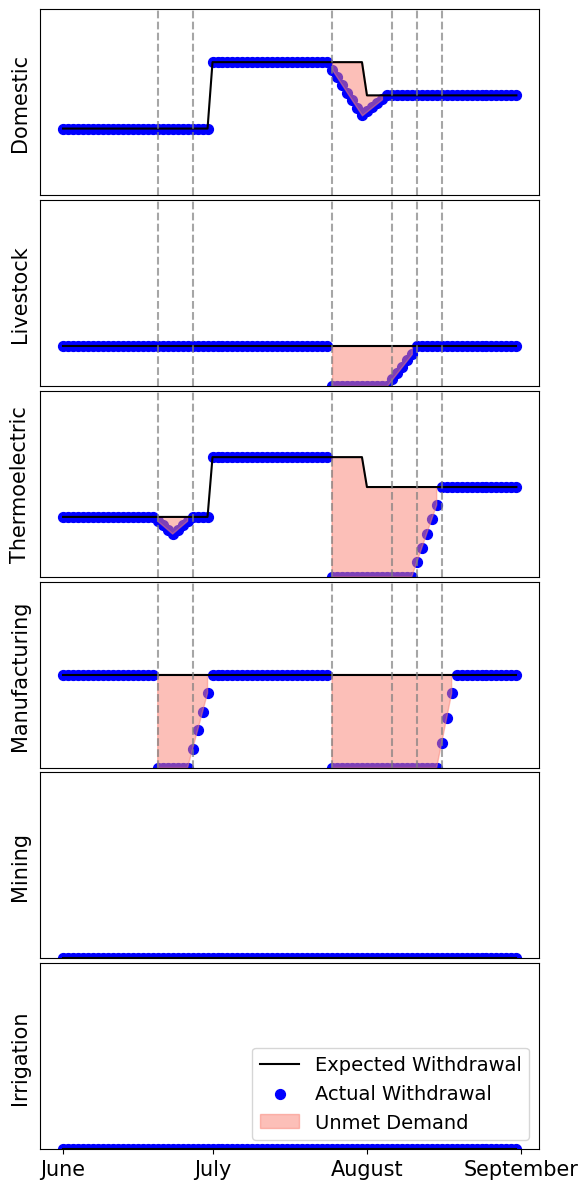

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.patches as mpatches


# Define the data
sectors = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining", "Irrigation"]
values = [1000, 300, 900, 700, 0, 0]
dates = np.arange(np.datetime64('2023-06-01'), np.datetime64('2023-09-01'))

# Function to generate constant values for each month
def constant_values(value, constant=False):
    if constant:
        return np.full((92,), value)
    else:
        june = np.full((30,), value * 0.5)
        july = np.full((31,), value)
        august = np.full((31,), value * 0.75)
        return np.concatenate((june, july, august))

# Function to generate Actual Withdrawal values with gradual drop and recover
def actual_values(values, sector):
    actual = values.copy()
    for idx, date in enumerate(dates):
        if np.datetime64('2023-06-20') <= date <= np.datetime64('2023-06-24'):
            if sector == "Thermoelectric":
                actual[idx] = actual[idx-1] - (values[idx] * 0.5) / 7 if idx > 0 else actual[idx] * 0.5
            elif sector in ["Manufacturing", "Mining", "Irrigation"]:
                actual[idx] = 0
        if np.datetime64('2023-06-24') <= date <= np.datetime64('2023-06-27'):
            if sector == "Thermoelectric":
                actual[idx] = actual[idx-1] + (values[idx] * 0.5) / 7 if idx > 0 else actual[idx] * 0.5
            elif sector in ["Manufacturing","Mining", "Irrigation"]:
                actual[idx] = 0
        if np.datetime64('2023-06-27') <= date <= np.datetime64('2023-06-30'):
            if sector == "Manufacturing":
                    actual[idx] = actual[idx-1] + (values[idx] * 0.5) / 2.5
                    
        elif np.datetime64('2023-07-25') <= date <= np.datetime64('2023-08-05'):
            if sector == "Domestic":
                if date < np.datetime64('2023-08-01'):
                    actual[idx] = actual[idx-1] - (values[idx] * 0.4) / 7 if idx > 0 else actual[idx] * 0.6
                else:
                    actual[idx] = actual[idx-1] + (values[idx] * 0.4) / 10 if idx > 0 else actual[idx] * 0.6
            else:
                actual[idx] = 0
        elif np.datetime64('2023-08-06') <= date <= np.datetime64('2023-08-10'):
            if sector == "Livestock":
                actual[idx] = actual[idx-1] + (values[idx] * 0.4) / 2.5
            elif sector in ["Thermoelectric","Manufacturing","Mining", "Irrigation"]:
                actual[idx] = 0
        elif np.datetime64('2023-08-11') <= date <= np.datetime64('2023-08-15'):
            if sector == "Thermoelectric":
                actual[idx] = actual[idx-1] + (values[idx] * 0.4) / 2.5
            elif sector in ["Manufacturing","Mining", "Irrigation"]:
                actual[idx] = 0
        elif np.datetime64('2023-08-16') <= date <= np.datetime64('2023-08-18'):
            if sector == "Manufacturing":
                actual[idx] = actual[idx-1] + (values[idx] * 0.4) / 1.5
            elif sector in ["Mining", "Irrigation"]:
                actual[idx] = 0
        elif sector == "Thermoelectric" and np.datetime64('2023-06-28') <= date <= np.datetime64('2023-06-27'):
            actual[idx] = actual[idx-1] + (values[idx] * 0.5) / 7 if idx > 0 else actual[idx] * 0.5
    # Prevent the Actual Withdrawal from exceeding Expected Withdrawal for Domestic sector
    if sector == "Domestic":
        actual = np.minimum(actual, values)
    return actual

# Create subplots with 6 rows and 1 column
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6, 12))

# Reorder the sectors based on the given order
ordered_sectors = ["Domestic", "Livestock", "Thermoelectric", "Manufacturing", "Mining", "Irrigation"]
ordered_values = [values[sectors.index(s)] for s in ordered_sectors]

# Extracting the specific dates for which vertical lines should be drawn
vertical_dates = [
    np.datetime64('2023-06-20'),
    np.datetime64('2023-06-27'),
    np.datetime64('2023-07-25'),
    np.datetime64('2023-08-06'),
    np.datetime64('2023-08-11'),
    np.datetime64('2023-08-16'),
]

# Plotting
for idx, ax in enumerate(axes):
    if ordered_sectors[idx] == "Manufacturing" or ordered_sectors[idx] == "Livestock":
        expected_data = constant_values(ordered_values[idx], constant=True)
    else:
        expected_data = constant_values(ordered_values[idx])

    actual_data = actual_values(expected_data, ordered_sectors[idx])

    ax.plot(dates, expected_data, label='Expected Withdrawal', color='k')
    ax.scatter(dates, actual_data, label='Actual Withdrawal', color="blue", s=50)
    
    # Shade the area where the actual withdrawal is lower than the expected withdrawal
    ax.fill_between(dates, actual_data, expected_data, where=(actual_data < expected_data), color='salmon', alpha=0.5)
    
    ax.set_ylim(0, 1400)
    ax.set_ylabel(f'{ordered_sectors[idx]}', fontsize=15)
    
    # Specify months instead of exact dates
    ax.xaxis.set_major_locator(mdates.MonthLocator()) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
    
    # Hide x-axis month values except for the last subplot
    if idx != len(axes) - 1:
        ax.set_xticklabels([])

    # Remove ticks for both x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Drawing vertical lines for each specified date
    if idx != 4 and idx != 5:
        for v_date in vertical_dates:
            ax.axvline(v_date, color='grey', linestyle='--', alpha=0.7)

        
# Create a custom patch for "Unmet Demand"
unmet_demand_patch = mpatches.Patch(color='salmon', alpha=0.5, label='Unmet Demand')

# Get existing handles and labels from axes[0] and add the custom patch
handles, labels = axes[0].get_legend_handles_labels()
handles.append(unmet_demand_patch)
labels.append(unmet_demand_patch.get_label())

# Update the legend with the new handle and label
axes[-1].legend(handles=handles, labels=labels,  loc='lower right', fontsize=14)

# Specify months instead of exact dates
axes[-1].xaxis.set_major_locator(mdates.MonthLocator()) 
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%B'))
# Increase the size of xticks for the last subplot (since only this one has x labels)
axes[-1].tick_params(axis='x', which='major', labelsize=15)

# axes[0].legend()


fig.tight_layout(h_pad=0)
plt.savefig("Results/png_format/FigureShowcaseAlgorithm.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()